1.Here in this process we are using an MNISt Dataset 
2.MNIST datasets are a Dataset consisting of 60000 trianed sample of Handwritten Data
and 10000 test data
3.Each example is a 28×28 grayscale image of a handwritten digit, with values ranging from 0 (white) to 255 (black). The label for each example is the digit that the image represents, with values ranging from 0 to 9.
4.An sample data from Mnist
It is a dataset commonly used for training and evaluating image classification models, particularly in the field of computer vision. It is considered a “Hello World” dataset for deep learning because it is small and relatively simple, yet still requires a non-trivial amount of preprocessing and model architecture design to achieve good performance.

In [72]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch.nn.functional as F
loop_counter=0

In [73]:
# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=torchvision.transforms.ToTensor(), 
                                           download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=torchvision.transforms.ToTensor(), 
                                          download=True)
print("Training Data",train_dataset)
print("Testing Data",test_dataset)

Training Data Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Testing Data Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [75]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [76]:
#Instantiate The model
model= Classifier()
#move the model to GPU 
model.to(device)
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
         Dropout2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
         MaxPool2d-5             [-1, 64, 7, 7]               0
         Dropout2d-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 128]         401,536
            Linear-8                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.43
Params size (MB): 1.61
Estimated Total Size (MB): 2.04
----------------------------------------------------------------


In [77]:
#Define a Loss Function and a Optimizer
criterion = nn.CrossEntropyLoss() #Softmax + NLL loss
optimizer= optim.Adam(model.parameters(),lr=0.001)

Training The Model

In [78]:
batch_size=100
num_epochs=10
#Split the Dataset into Training and validation sets
val_percent=0.2#20% split will be used for Validation
val_size=int(val_percent*len(train_dataset))
train_size= len(train_dataset)-val_size
train_dataset,val_dataset=torch.utils.data.random_split(train_dataset,[train_size,val_size])
# Creating Dataloaders For Training and Validation Set
train_dataloader=torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, 
                                         batch_size=batch_size, 
                                         shuffle=False,
                                         pin_memory=True)
losses = []
accuracies = []
val_losses = []
val_accuracies = []
for epochs in range(num_epochs):
    for i,(images,labels) in enumerate(train_dataloader):
        # Forward pass to calculate loss
        images= images.to(device)
        labels= labels.to(device)
        outputs = model(images)
        loss= criterion(outputs,labels)
        # Backward pass to optimize values
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
    acc = (predicted == labels).sum().item() / labels.size(0)
    accuracies.append(acc)
    losses.append(loss.item())  
 # Evaluate the model on the validation set
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            labels=labels.to(device)
            loop_counter= loop_counter+1
            images=images.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
              
            _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        val_acc += correct / total
        val_accuracies.append(acc)
        val_losses.append(loss.item())  
      
              
    print('Epoch [{}/{}],Loss:{:.4f},Validation Loss:{:.4f},Accuracy:{:.2f},Validation Accuracy:{:.2f}'.format(
        epochs+1, num_epochs, loss.item(), val_loss, acc ,val_acc))   
    print(loop_counter)     

Epoch [1/10],Loss:0.1036,Validation Loss:14.5709,Accuracy:0.96,Validation Accuracy:0.96
120
Epoch [2/10],Loss:0.1552,Validation Loss:11.1837,Accuracy:0.97,Validation Accuracy:0.93
240
Epoch [3/10],Loss:0.0354,Validation Loss:8.5753,Accuracy:0.97,Validation Accuracy:0.99
360
Epoch [4/10],Loss:0.0567,Validation Loss:8.6379,Accuracy:0.99,Validation Accuracy:0.98
480
Epoch [5/10],Loss:0.0765,Validation Loss:7.0686,Accuracy:0.98,Validation Accuracy:0.97
600
Epoch [6/10],Loss:0.0309,Validation Loss:6.8183,Accuracy:1.00,Validation Accuracy:0.99
720
Epoch [7/10],Loss:0.0145,Validation Loss:6.4007,Accuracy:0.98,Validation Accuracy:0.99
840
Epoch [8/10],Loss:0.0279,Validation Loss:6.3067,Accuracy:0.99,Validation Accuracy:0.99
960
Epoch [9/10],Loss:0.0404,Validation Loss:7.2203,Accuracy:1.00,Validation Accuracy:0.98
1080
Epoch [10/10],Loss:0.0456,Validation Loss:6.8416,Accuracy:1.00,Validation Accuracy:0.98
1200


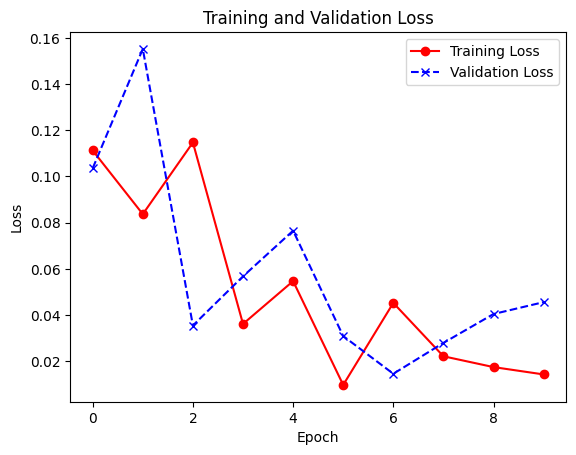

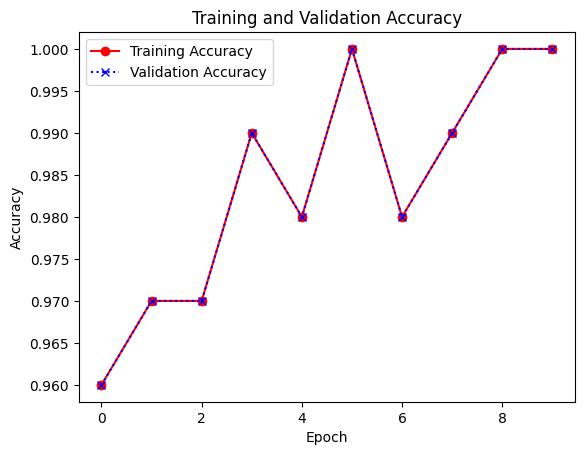

In [79]:
import matplotlib.pyplot as plt

# Plot the training and validation loss over time
plt.plot(range(num_epochs),
		losses, color='red',
		label='Training Loss',
		marker='o')
plt.plot(range(num_epochs),
		val_losses,
		color='blue',
		linestyle='--',
		label='Validation Loss',
		marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy over time
plt.plot(range(num_epochs),
		accuracies,
		label='Training Accuracy',
		color='red',
		marker='o')
plt.plot(range(num_epochs),
		val_accuracies,
		label='Validation Accuracy',
		color='blue',
		linestyle=':',
		marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()